In [49]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

In [50]:
import os
import sys
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib import NERCOME, shrinkage

In [51]:
# Parameters
p = 30
n = 100

# Build true covariance matrix
#cov = np.full((p, p), 1)
#np.fill_diagonal(cov, 5)

cov = np.zeros((p,p))
c = np.flip(np.linspace(0,1,p))
for i in range(len(c)):
    np.fill_diagonal(cov[i:], c[i])
    np.fill_diagonal(cov[:,i:], c[i])

# Target
T = np.full((p, p), 0.2)
np.fill_diagonal(T, 1)

# Means of the data realizations
means = np.full(p, 0)

# Random generator
rng = np.random.default_rng()

In [54]:
MSE_sample_all = []
MSE_shrinkage_all = []
MSE_nercome_all = []

evals_MC_sum = np.zeros(p)
evals_MCS_sum = np.zeros(p)
evals_NERCOME_sum = np.zeros(p)

lmbda_est_all = []
s_min_all = []

m = 3 # nr of simulations
for _ in range(m):
    # Generate random matrix, each column represents one realization of the data
    X = rng.multivariate_normal(means, cov, n).T

    cov_shrinkage, S1, lmbda_est = shrinkage.shrinkage_cov_matrix(X, T)
    cov_nercome, S2, s_min = NERCOME.NERCOME(X)
    
    evals_MC = np.linalg.eigvalsh(S1)
    evals_MCS = np.linalg.eigvalsh(cov_shrinkage)
    evals_NERCOME = np.linalg.eigvalsh(cov_nercome)
    
    evals_MC_sum += evals_MC
    evals_MCS_sum += evals_MCS
    evals_NERCOME_sum += evals_NERCOME
    
    lmbda_est_all.append(lmbda_est)
    s_min_all.append(s_min)
    
    MSE_sample = np.trace((S1-cov)@(S1-cov).T)
    MSE_shrinkage = np.trace((cov_shrinkage-cov)@(cov_shrinkage-cov).T)
    MSE_nercome = np.trace((cov_nercome-cov)@(cov_nercome-cov).T)
    
    MSE_sample_all.append(MSE_sample)
    MSE_shrinkage_all.append(MSE_shrinkage)
    MSE_nercome_all.append(MSE_nercome)

MSE_sample = np.average(MSE_sample_all)
MSE_shrinkage = np.average(MSE_shrinkage_all)
MSE_nercome = np.average(MSE_nercome_all)

MSE_sample_se = np.std(MSE_sample_all) / np.sqrt(m)
MSE_shrinkage_se = np.std(MSE_shrinkage_all) / np.sqrt(m)
MSE_nercome_se = np.std(MSE_nercome_all) / np.sqrt(m)

evals_MC = evals_MC_sum / m
evals_MCS = evals_MCS_sum / m
evals_NERCOME_sum = evals_NERCOME / m

lmbda_est = np.average(lmbda_est_all)
lmbda_est_se = np.std(lmbda_est_all) / np.sqrt(m)

s_min = np.average(s_min_all)
s_min_se = np.std(s_min_all) / np.sqrt(m)

print(f"Lambda: {lmbda_est} ± {lmbda_est_se}")
print(f"s which minimizes Q: {s_min} ± {s_min_se}")

print(f"MSE sample: {MSE_sample} ± {MSE_saple_se}")
print(f"MSE shrinkage: {MSE_shrinkage} ± {MSE_shrinkage_se}")
print(f"MSE nercome: {MSE_nercome} ± {MSE_nercome_se}")

Lambda: 0.05175020943659268 ± 0.0019571732023337322
s which minimizes Q: 83.33333333333333 ± 2.7216552697590863
MSE sample: 7.594211656602539 ± 2.945622017024421
MSE shrinkage: 6.449890817875242 ± 1.9359034426600146
MSE nercome: 12.522658688035117 ± 2.811223563481776


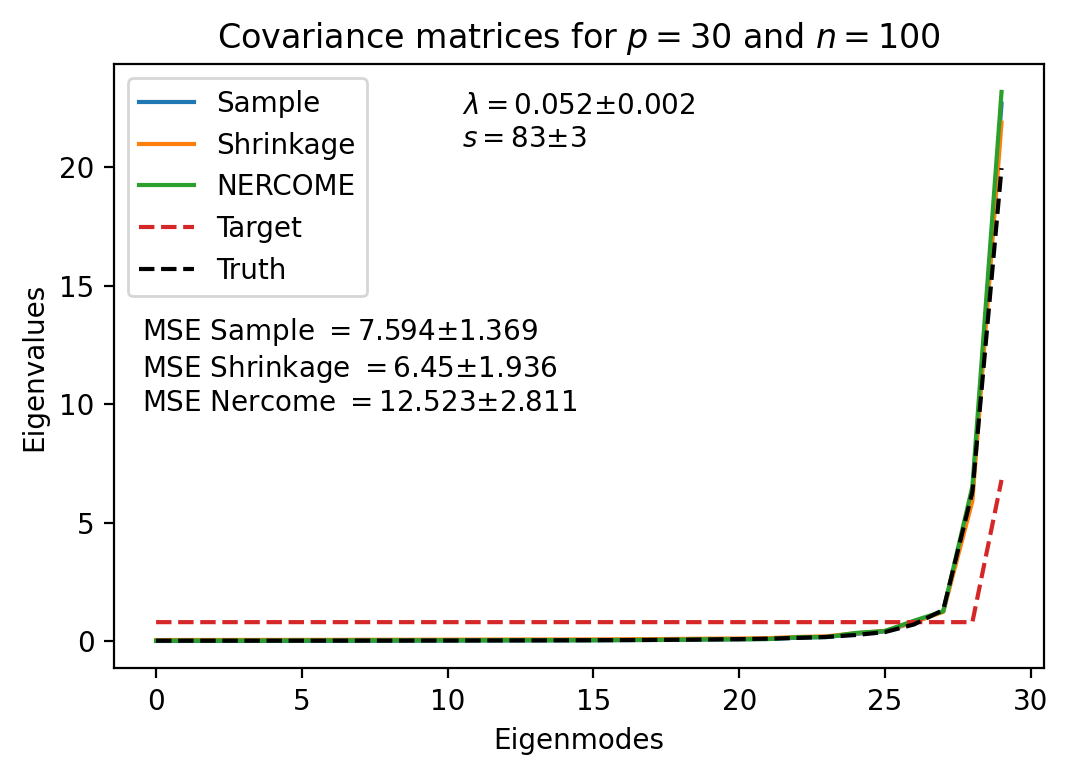

In [62]:
evals_T = np.linalg.eigvalsh(T)
evals_true = np.linalg.eigvalsh(cov)

plt.figure(dpi=200)
plt.plot(evals_sample, label="Sample")
plt.plot(evals_shrinkage, label="Shrinkage")
plt.plot(evals_nercome, label="NERCOME")
plt.plot(evals_target, "--", label="Target")
plt.plot(evals_cov, "k--", label="Truth")
plt.legend()
plt.title(fr"Covariance matrices for $p={p}$ and $n={n}$")
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")

estimator_parameters = AnchoredText(
    fr"$\lambda = {np.round(lmbda_est, 3)} ± {np.round(lmbda_est_se, 3)}$"
    "\n"
    fr"$s = {int(np.rint(s_min))} ± {int(np.rint(s_min_se))}$",
    frameon=False, loc="upper center", pad=0.5
)
plt.setp(estimator_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(estimator_parameters)

error_parameters = AnchoredText(
    fr"MSE Sample $= {np.round(MSE_sample, 3)} ± {np.round(MSE_sample_se, 3)}$"
    "\n"
    fr"MSE Shrinkage $= {np.round(MSE_shrinkage, 3)} ± {np.round(MSE_shrinkage_se, 3)}$"
    "\n"
    fr"MSE Nercome $= {np.round(MSE_nercome, 3)} ± {np.round(MSE_nercome_se, 3)}$",
    frameon=False, loc="center left", pad=0.5
)
plt.setp(error_parameters.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(error_parameters)

In [45]:
# Generate random matrix, each column represents one realization of the data
X = rng.multivariate_normal(means, cov, n).T

cov_shrinkage, S1, lmbda_est = shrinkage.shrinkage_cov_matrix(X, T)
cov_nercome, S2, s_min = NERCOME.NERCOME(X)

In [46]:
evals_cov = np.linalg.eigvalsh(cov)
evals_sample = np.linalg.eigvalsh(S1)
evals_shrinkage = np.linalg.eigvalsh(cov_shrinkage)
evals_nercome = np.linalg.eigvalsh(cov_nercome)
evals_target = np.linalg.eigvalsh(T)

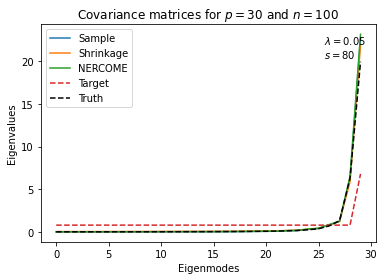

In [47]:
plt.plot(evals_sample, label="Sample")
plt.plot(evals_shrinkage, label="Shrinkage")
plt.plot(evals_nercome, label="NERCOME")
plt.plot(evals_target, "--", label="Target")
plt.plot(evals_cov, "k--", label="Truth")
plt.legend()
plt.title(fr"Covariance matrices for $p={p}$ and $n={n}$")
plt.xlabel("Eigenmodes")
plt.ylabel("Eigenvalues")

text_box = AnchoredText(
    fr"$\lambda = {np.round(lmbda_est, 3)}$" "\n" fr"$s = {int(np.rint(s_min))}$",
    frameon=False, loc=1, pad=0.5
)
plt.setp(text_box.patch, facecolor='white', alpha=0.5)
plt.gca().add_artist(text_box)

In [48]:
MSE_sample = np.trace((S1-cov)@(S1-cov).T)
MSE_shrinkage = np.trace((cov_shrinkage-cov)@(cov_shrinkage-cov).T)
MSE_nercome = np.trace((cov_nercome-cov)@(cov_nercome-cov).T)
print(MSE_sample)
print(MSE_shrinkage)
print(MSE_nercome)

print()

9.228612936843188
5.597089426228419
12.349958536779106



In [37]:
print(evals_cov)

[1.72887341e-02 1.74313854e-02 1.76738902e-02 1.80184151e-02
 1.84792547e-02 1.90568190e-02 1.97819241e-02 2.06493869e-02
 2.17175204e-02 2.29703140e-02 2.45125900e-02 2.63094939e-02
 2.85474169e-02 3.11594481e-02 3.44827586e-02 3.83955150e-02
 4.35339825e-02 4.96806581e-02 5.81238639e-02 6.84787303e-02
 8.36524137e-02 1.02990050e-01 1.34249811e-01 1.76615186e-01
 2.57382814e-01 3.79319894e-01 7.04542383e-01 1.31544142e+00
 6.29465133e+00 1.99548626e+01]
